<h1> Using Machine Learning Models </h1>

Now that the data has been cleaned by stemming and lemmatizing the words, explored and featurized using techniques like TFIDF and Word2Vec, the last and final stage in the pipeline is to train a Machine Learning model on the data. The data was initially in the form of title and body which was then converted to a combined sparse matrix representation. <br>

The task is to classify news articles as <em>Fake</em> or not. Here,<br>
* Class 0 --> <em>Not Fake</em><br>
* Class  1 --> <em>Fake</em> <br>

In the process of data cleaning, a stemmed and lemmatized version of cleaned data was extracted. The stemmed data has been used along with TFIDF to featurize the data whereas the lemmatized data has been used with W2V as lemmatized data works better with W2V. Also, along with TFIDF vectorization, we will be experimenting with unigrams and bigrams to see if bigrams capture information better. Before moving onto trainng models on the data, it is important to establish some business constraints and objectives.

## Real World / Business constraints

1) __Model Interpretability__ - Interpretability is not really important for our use case here since we only want to know if an article is Fake or Legit. Since labelling incorrectly doesn't have consequences that are severe, model interpretability is not a priority. <br>
2) __Latency Constraint__ - There is no latency constrain at hand as we don't have to predict whether an article is <em>Fake</em> or <em>Legit</em> in a span of few microseconds or seconds. Thus, even if the model takes a few seconds or minutes it is fine. <br>
3) __Cost of Misclassication__ - The cost of misclassification isn't very high. Sure, we'd like it if legitimate articles aren't marked as Fake and vice versa as that could discredit an author of their work but the cost of misclassification isn't as severe as say, diagnosing someone of some medical disease or detecting fraud. Thus we can say that the cost of misclassification is not high or low but moderate.

## Evaluation Metrics

Firstly its good to have an understanding of what False negatives and False positives would mean for this case.<br>

__False Positive__ : Model classifies an article as <em>Fake</em> but it wasn't <em>Fake</em> <br>
__False Negative__ : Model classifies an article as <em>Not Fake</em> but it was actually <em>Fake</em><br>

**Tradeoff between False Positives and False Negatives**: <br>
If the model is having more False positives, it would be bad as we would be wrongly classifying an author's article as Fake and that would completely discredit their work. This would thus lead to bad user experience for an author. <br>
Similarly, if the model is having more False negatives, it woulld perhaps be a little worse than previous case since we'll be letting False information through and we don't want that at all. <br>
Typically, if we want to focus more on the False Negatives, we would use Recall as the metric and precision if we want to focus on False Positives.<br>

**Understanding difference between Recall and Precision for the use case**:
* <em>Precision</em> : Of all the points that the model has classified as Fake (class 1), how many points were actually Fake?
* <em>Recall</em> : Of all the points that were Fake, how many points did the model actually classify as Fake?

However, since we would want to penalize both False negatives and False positives, a metric that gives both precision and Recall importance is the <em>**F1 Score**</em><br>
The <em>**F1 Score**</em> is the harmonic mean of precision and recall. <br>
Also, since the dataset is pretty balanced, another good metric that can be used and is fairly easy to interpret is **<em>Accuracy</em>** paired with the **<em>Confusion Matrix</em>**<br>

Thus the evatuation metrics are as follows:<br>
1)  <em>**F1 Score**</em><br>
2)  <em>**Accuracy**</em> and <em>**Confusion Matrix**</em>

### Importing Libraries 

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Since we dropped the y-labels during train test split, we can simply mimic the process of train test split with same random_seed as used before to get the same splits as done before
# We can use the stemmed data as before and drop the NA values just like it was done previously

stemmed_data = pd.read_csv('data/stemmed_clean_data')
stemmed_data = stemmed_data.dropna() # Dropping the NaN values

x = stemmed_data.drop('label', axis=1)
y = stemmed_data['label']

_,_, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (54744,)
y_test shape: (13686,)


In [3]:
# Defining a function that trains a model on the data using default hyper-params annd returns their performance on the test set. Whichever model is performing best, we'll try tuning the hyper-params for that model only

def train_model(clf, X_train, y_train, X_test, y_test):
    
    """
    Trains the model on the training data and prints the classification report and confusion matrix on test data
    
    Input: 
        clf: classifier object
        X_train: Training data
        y_train: Training labels
        X_test: Test data
        y_test: Test labels
    
    """
    
    clf.fit(X_train, y_train)  # Training the model
    
    # Getting predictions on both the train and test set
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    print('_'*60)
    print()
    print('Train set report:\n')
    print(classification_report(y_train,  y_train_pred))
    print()
    
    print('*'*60)
    print()
    
    print('Test set report:\n')
    print(classification_report(y_test, y_test_pred))
    print('_'*60)
    print('\n\n')
    
    print(f"Train F1 score: {round(f1_score(y_train, y_train_pred),3)}")
    print(f"Test F1 score: {round(f1_score(y_test, y_test_pred),3)}\n")
    
    print(f"Train Accuracy: {round(accuracy_score(y_train, y_train_pred),3)}")
    print(f"Test Accuracy: {round(accuracy_score(y_test, y_test_pred),3)}\n")
    
    print('_'*60)
    print()
    
    
    # Plotting the heatmap of the confusion matrix for TEST data 
    # Reference: # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap='BuGn', ax = ax, fmt='d'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not Fake', 'Fake']); ax.yaxis.set_ticklabels(['Not Fake', 'Fake']);
    plt.show()

## TFIDF with Unigrams

Since we're using TFIDF the dimensionality of data is high. Two Machine Learning models that are known to perform well with high dimensional data are Naive Bayes classifier and Logistic Regression. <br>
We'll specifically be using Multinomial Naive Bayes as it is known to work really well with text data (sparse datasets).

In [9]:
# Loading in the data

train_tfidf_unigram = sp.sparse.load_npz('featurizations/tfidf_features2.npz')
test_tfidf_unigram = sp.sparse.load_npz('featurizations/test_tfidf_features2.npz')

In [10]:
# Checking the shape

print(f"Shape of train data with unigrams: {train_tfidf_unigram.shape}")
print(f"Shape of test data with unigrams: {test_tfidf_unigram.shape}")

Shape of train data with unigrams: (54744, 3159)
Shape of test data with unigrams: (13686, 3159)


* With unigrams and TFIDF, there are about 3159 features that were extracted from the titles and articles totally

#### Multinomial Naive Bayes

In [65]:
clf_nb = MultinomialNB()

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     26936
           1       0.90      0.90      0.90     27808

    accuracy                           0.90     54744
   macro avg       0.90      0.90      0.90     54744
weighted avg       0.90      0.90      0.90     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6734
           1       0.90      0.90      0.90      6952

    accuracy                           0.90     13686
   macro avg       0.90      0.90      0.90     13686
weighted avg       0.90      0.90      0.90     13686

____________________________________________________________



Train F1 score: 0.901
Test F1 score: 0.9

Train Accuracy: 0.9
Test Accuracy: 0.898

____________________________________

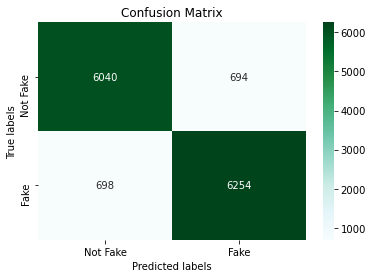

In [66]:
train_model(clf_nb, train_tfidf_unigram, y_train, test_tfidf_unigram, y_test)

#### Logistic Regression

In [59]:
clf_lr = LogisticRegression()

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     26936
           1       0.97      0.98      0.97     27808

    accuracy                           0.97     54744
   macro avg       0.97      0.97      0.97     54744
weighted avg       0.97      0.97      0.97     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6734
           1       0.96      0.97      0.97      6952

    accuracy                           0.97     13686
   macro avg       0.97      0.97      0.97     13686
weighted avg       0.97      0.97      0.97     13686

____________________________________________________________



Train F1 score: 0.972
Test F1 score: 0.968

Train Accuracy: 0.972
Test Accuracy: 0.967

________________________________

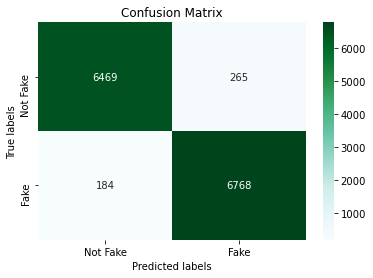

In [60]:
train_model(clf_lr, train_tfidf_unigram, y_train, test_tfidf_unigram, y_test)

#### Conclusion and Takeaways:
* Logistic Regression outperforms the Multinomial Naive Bayes model by a huge margin.
* With Naive Bayes we are getting a test accuracy of about 89.8% and a test F1 score of 0.9
* With Logistic Regression we are getting a test accuracy of about 96.7% and a test F1 score of 0.968
* There is no overfitting at all for both the models

## TFIDF with Bigrams
The models are doing pretty well already with Unigrams. The idea of using Bigrams comes from the fact that words like 'Donald Trump' and 'Hilary Clinton' occur a lot. But with unigrams we aren't able to capture that semantic information.<br>
Also, by using bi-grams, the number of dimensions increase dramatically to over 46k. Compared to unigrams, where we had just a little over 3k features, bigrams have 12x more features.

In [4]:
# Loading the data

train_tfidf_bigram = sp.sparse.load_npz('featurizations/tfidf_features.npz')
test_tfidf_bigram = sp.sparse.load_npz('featurizations/test_tfidf_features.npz')

#### Multinomial Naive Bayes

In [68]:
clf_nb = MultinomialNB()

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     26936
           1       0.92      0.93      0.93     27808

    accuracy                           0.93     54744
   macro avg       0.93      0.93      0.93     54744
weighted avg       0.93      0.93      0.93     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      6734
           1       0.92      0.93      0.92      6952

    accuracy                           0.92     13686
   macro avg       0.92      0.92      0.92     13686
weighted avg       0.92      0.92      0.92     13686

____________________________________________________________



Train F1 score: 0.929
Test F1 score: 0.922

Train Accuracy: 0.928
Test Accuracy: 0.921

________________________________

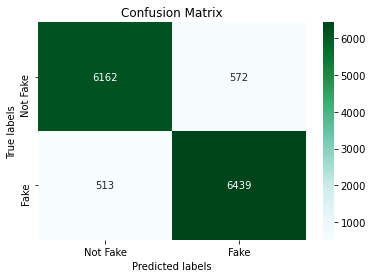

In [69]:
train_model(clf_nb, train_tfidf_bigram, y_train, test_tfidf_bigram, y_test)

#### Logistic Regression

In [72]:
clf_lr = LogisticRegression()

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26936
           1       0.99      0.99      0.99     27808

    accuracy                           0.99     54744
   macro avg       0.99      0.99      0.99     54744
weighted avg       0.99      0.99      0.99     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6734
           1       0.97      0.98      0.98      6952

    accuracy                           0.98     13686
   macro avg       0.98      0.98      0.98     13686
weighted avg       0.98      0.98      0.98     13686

____________________________________________________________



Train F1 score: 0.989
Test F1 score: 0.979

Train Accuracy: 0.989
Test Accuracy: 0.979

________________________________

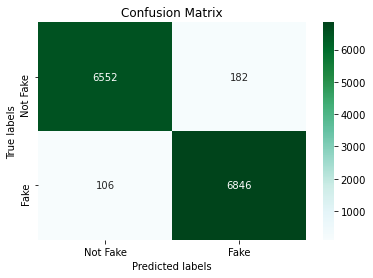

In [73]:
train_model(clf_lr, train_tfidf_bigram, y_train, test_tfidf_bigram, y_test)

#### Conclusion and Takeaways:
* Here too, Logistic Regression outperforms the Multinomial Naive Bayes model by a huge margin
* Its clear that the model are certainly performing better with bigrams
* With naive bayes we are getting a test accuracy of 92.1% and a test F1 score of 0.922
* With Logistic Regression we are getting a test accuracy of 97.9% (98% approx) and a test F1 score of 0.979
* Test accuracy for logistic regression with Unigrams was 96.7% and with Bigrams it is 97.9%
* While the jump in accuracy is not significant, it is enough as the model with unigrams was already performing really good.<br> Since there aren't any latency constraints, its okay to use Bigrams with 46k dimensions

<h1> Pre-trained Google-news-Word2Vec on Title

With respect to Word2Vec, there are two approaches that can be taken. <br>
* Pre-trained Word2Vec on a big corpus
* Avg-Word2Vec trained on our corpus <br>

The pre-trained model that we've used here is the *Gensim Word2Vec model trained on Google News Data* <br>
We use this to calculate avg-word2Vec features(300 dimentions) on our corpus.
This is only done on the title, article and finally a combination of both to get a sense of how important and useful these features can be
<br>
We have tried some Machine Learning Models on these features and tried to compare it with the results we got using other features

In [16]:
# Loading in the data

train_googlew2v = sp.sparse.load_npz('D:/MajorProject_Code/Data/title_w2vgoogle.npz')
test_googlew2v = sp.sparse.load_npz('D:/MajorProject_Code/Data/test_title_w2vgoogle.npz')

In [18]:
# Checking the shape

print(f"Shape of train title data with Pre-trained Word2Vec Features: {train_googlew2v.shape}")
print(f"Shape of test title data with Pre-trained Word2Vec Features: {test_googlew2v.shape}")

Shape of train title data with Pre-trained Word2Vec Features: (54744, 300)
Shape of test title data with Pre-trained Word2Vec Features: (13686, 300)


* When we use pre-trained Word2vec features, we end up with 300 dimensions, which is a lot lesser than that of Tf-idf. 

<h4> Gaussian Naive Bayes

* *Gaussian Naive Bayes* is used instead of multinomial to tackle the negative feature values as a result of word2vec 

In [25]:
clf_nb2 = GaussianNB()

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     26936
           1       0.81      0.79      0.80     27808

    accuracy                           0.80     54744
   macro avg       0.80      0.80      0.80     54744
weighted avg       0.80      0.80      0.80     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      6734
           1       0.82      0.79      0.80      6952

    accuracy                           0.80     13686
   macro avg       0.80      0.80      0.80     13686
weighted avg       0.80      0.80      0.80     13686

____________________________________________________________



Train F1 score: 0.804
Test F1 score: 0.802

Train Accuracy: 0.803
Test Accuracy: 0.802

________________________________

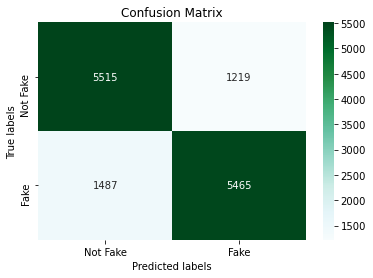

Wall time: 725 ms


In [29]:
%%time

train_model(clf_nb2, train_googlew2v.toarray(), y_train, test_googlew2v.toarray(), y_test)

<h4> Logistic Regression

In [27]:
clf_lr2 = LogisticRegression()

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.84      0.83      0.84     26936
           1       0.84      0.85      0.85     27808

    accuracy                           0.84     54744
   macro avg       0.84      0.84      0.84     54744
weighted avg       0.84      0.84      0.84     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      6734
           1       0.85      0.85      0.85      6952

    accuracy                           0.85     13686
   macro avg       0.85      0.85      0.85     13686
weighted avg       0.85      0.85      0.85     13686

____________________________________________________________



Train F1 score: 0.846
Test F1 score: 0.849

Train Accuracy: 0.842
Test Accuracy: 0.846

________________________________

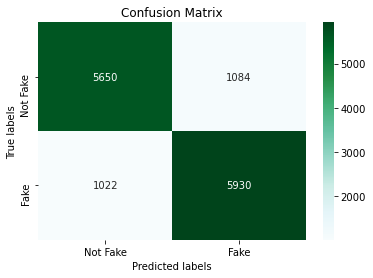

Wall time: 2.72 s


In [28]:
%%time

train_model(clf_lr2, train_googlew2v, y_train, test_googlew2v, y_test)

<h4> Random Forest

In [32]:
clf_rf = RandomForestClassifier()

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26936
           1       1.00      1.00      1.00     27808

    accuracy                           1.00     54744
   macro avg       1.00      1.00      1.00     54744
weighted avg       1.00      1.00      1.00     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      6734
           1       0.87      0.84      0.85      6952

    accuracy                           0.85     13686
   macro avg       0.85      0.85      0.85     13686
weighted avg       0.86      0.85      0.85     13686

____________________________________________________________



Train F1 score: 1.0
Test F1 score: 0.854

Train Accuracy: 1.0
Test Accuracy: 0.855

____________________________________

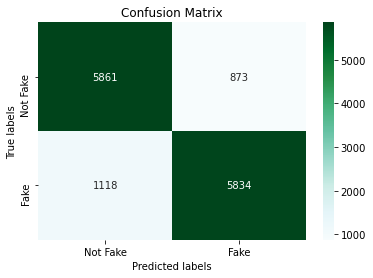

Wall time: 7min 23s


In [33]:
%%time

train_model(clf_rf, train_googlew2v, y_train, test_googlew2v, y_test)

#### Conclusion and Takeaways:
* Logistic Regression performs better than the Guassian Naive Bayes
* With Naive Bayes we are getting a test accuracy of about 80% and a test F1 score of 0.802
* With Logistic Regression we are getting a test accuracy of about 84% and a test F1 score of 0.849
* With the Random Forest Model, we do see some overfitting and also proves a point that Random Forest doesn't work well with high dimensional data

<h1> Pre-trained Google-news-Word2Vec on Article body

* Just like the models were trained on the *Pretrained-Word2Vec-Title* feature. We try the same on the *Pretrained-Word2Vec-Body* feature in this segment
* These Body features should do better than the title as they contain way more information than the title and are 10times bigger than the title on average

In [6]:
# Loading in the data

train_body_googlew2v = sp.sparse.load_npz('D:/MajorProject_Code/Data/body_w2vgoogle.npz')
test_body_googlew2v = sp.sparse.load_npz('D:/MajorProject_Code/Data/test_body_w2vgoogle.npz')

In [7]:
# Checking the shape

print(f"Shape of train title data with Pre-trained Word2Vec Features: {train_body_googlew2v.shape}")
print(f"Shape of test title data with Pre-trained Word2Vec Features: {test_body_googlew2v.shape}")

Shape of train title data with Pre-trained Word2Vec Features: (54744, 300)
Shape of test title data with Pre-trained Word2Vec Features: (13686, 300)


<h4> Gaussian Naive Bayes

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.70      0.82      0.76     26936
           1       0.79      0.66      0.72     27808

    accuracy                           0.74     54744
   macro avg       0.75      0.74      0.74     54744
weighted avg       0.75      0.74      0.74     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.70      0.82      0.76      6734
           1       0.79      0.66      0.72      6952

    accuracy                           0.74     13686
   macro avg       0.75      0.74      0.74     13686
weighted avg       0.75      0.74      0.74     13686

____________________________________________________________



Train F1 score: 0.722
Test F1 score: 0.721

Train Accuracy: 0.741
Test Accuracy: 0.74

_________________________________

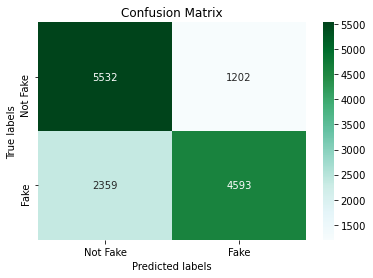

Wall time: 820 ms


In [8]:
%%time

clf_nb = GaussianNB()
train_model(clf_nb, train_body_googlew2v.toarray(), y_train, test_body_googlew2v.toarray(), y_test)

<h4> Logistic Regression

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     26936
           1       0.88      0.89      0.89     27808

    accuracy                           0.88     54744
   macro avg       0.88      0.88      0.88     54744
weighted avg       0.88      0.88      0.88     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      6734
           1       0.88      0.89      0.89      6952

    accuracy                           0.88     13686
   macro avg       0.88      0.88      0.88     13686
weighted avg       0.88      0.88      0.88     13686

____________________________________________________________



Train F1 score: 0.885
Test F1 score: 0.887

Train Accuracy: 0.883
Test Accuracy: 0.885

________________________________

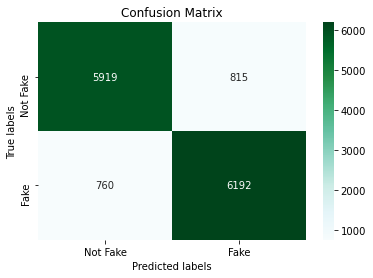

Wall time: 3.98 s


In [11]:
%%time

clf_lr = LogisticRegression(max_iter = 1000)
train_model(clf_lr, train_body_googlew2v, y_train, test_body_googlew2v, y_test)

#### Conclusion and Takeaways:
* With naive bayes on the article body, we see that there is a dip in performance as comapared to naive bayes on the titles
* Logistic Regression's accuracy when we use article body goes up to 88.5% from previous accuracy of 85.5%

<h1> Pre-trained Google-news-Word2Vec on Title and body combined

In [4]:
# Loading in the data

train_w2vgoogle = sp.sparse.load_npz('featurizations/w2vgoogle.npz')
test_w2vgoogle = sp.sparse.load_npz('featurizations/test_w2vgoogle.npz')

In [12]:
# Checking the shape

print(f"Shape of train title data with Pre-trained Word2Vec Features: {train_w2vgoogle.shape}")
print(f"Shape of test title data with Pre-trained Word2Vec Features: {test_w2vgoogle.shape}")

Shape of train title data with Pre-trained Word2Vec Features: (54744, 600)
Shape of test title data with Pre-trained Word2Vec Features: (13686, 600)


<h4> Gaussian Naive Bayes

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.75      0.84      0.79     26936
           1       0.83      0.72      0.77     27808

    accuracy                           0.78     54744
   macro avg       0.79      0.78      0.78     54744
weighted avg       0.79      0.78      0.78     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      6734
           1       0.82      0.72      0.77      6952

    accuracy                           0.78     13686
   macro avg       0.78      0.78      0.78     13686
weighted avg       0.78      0.78      0.78     13686

____________________________________________________________



Train F1 score: 0.772
Test F1 score: 0.767

Train Accuracy: 0.782
Test Accuracy: 0.779

________________________________

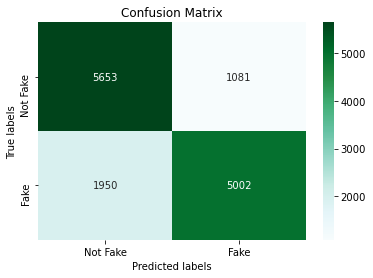

Wall time: 1.41 s


In [9]:
%%time

clf_nb = GaussianNB()
train_model(clf_nb, train_w2vgoogle.toarray(), y_train, test_w2vgoogle.toarray(), y_test)

<h4> Logistic Regression

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     26936
           1       0.91      0.92      0.91     27808

    accuracy                           0.91     54744
   macro avg       0.91      0.91      0.91     54744
weighted avg       0.91      0.91      0.91     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6734
           1       0.91      0.92      0.91      6952

    accuracy                           0.91     13686
   macro avg       0.91      0.91      0.91     13686
weighted avg       0.91      0.91      0.91     13686

____________________________________________________________



Train F1 score: 0.915
Test F1 score: 0.915

Train Accuracy: 0.912
Test Accuracy: 0.913

________________________________

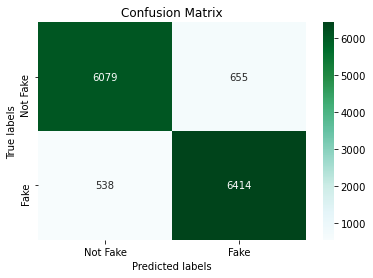

Wall time: 10.2 s


In [10]:
%%time

clf_lr = LogisticRegression(max_iter = 1000)
train_model(clf_lr, train_w2vgoogle, y_train, test_w2vgoogle, y_test)

<h4> XGBoost Classifier

[15:40:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26936
           1       1.00      1.00      1.00     27808

    accuracy                           1.00     54744
   macro avg       1.00      1.00      1.00     54744
weighted avg       1.00      1.00      1.00     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6734
           1       0.92      0.94      0.93      6952

    accuracy                         

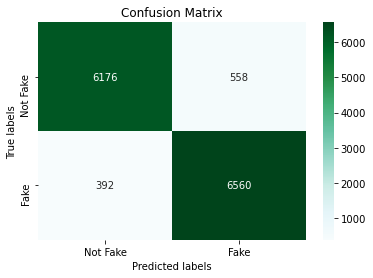

Wall time: 2min 11s


In [13]:
%%time

clf_xgb = XGBClassifier(n_jobs=-1)
train_model(clf_xgb, train_w2vgoogle, y_train, test_w2vgoogle, y_test)

#### Conclusion and Takeaways:
* With Logistic Regression, with default hyperparameters we're able to achieve an accuracy of 91.3%
* XGBoost achieves a test accuracy of 93.1% and train accuracy of 99.7%. Tuning the XGBoost can very well yield amazing results

<h1> Extracted Avg-Word2Vec features from our corpus

In the previous section, we experimented with the features extracted from a pre-trained Word2Vec model which was originally trained on Google-news Data. <br>
Now, in this section we are going to work with Word2Vec features that we extracted from our data by training a Word2Vec model and tuning the parameters according to our needs.<br>
The same is available in the *feature extraction* notebook.

* These features are a combination of title and article body features
* We do not work on the title and body word2Vec seperately because it doesn't have the same dimensions and information as the pre-trained google news word2Vec features had
* This is the reason we directly combine them and use them and try to see if they add any value by training some simple Machine Learning models on them

In [36]:
# Loading in the data

train_avgw2v = sp.sparse.load_npz('D:/MajorProject_Code/Data/avg_w2v.npz')
test_avgw2v = sp.sparse.load_npz('D:/MajorProject_Code/Data/test_avgw2v.npz')

In [37]:
# Checking the shape

print(f"Shape of train title data with Pre-trained Word2Vec Features: {train_avgw2v.shape}")
print(f"Shape of test title data with Pre-trained Word2Vec Features: {test_avgw2v.shape}")

Shape of train title data with Pre-trained Word2Vec Features: (54744, 200)
Shape of test title data with Pre-trained Word2Vec Features: (13686, 200)


* The hyper-parameter for number of dimensions was set to 100 for title and body when the Word2Vec feratures were extracted. Hence we get 200 dimentional data when we combine the w2v-features of title and body

<h4> Logistic Regression

In [56]:
clf_lr = LogisticRegression(max_iter = 1000)

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       0.85      0.81      0.83     26936
           1       0.82      0.86      0.84     27808

    accuracy                           0.83     54744
   macro avg       0.83      0.83      0.83     54744
weighted avg       0.83      0.83      0.83     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      6734
           1       0.81      0.87      0.84      6952

    accuracy                           0.83     13686
   macro avg       0.83      0.83      0.83     13686
weighted avg       0.83      0.83      0.83     13686

____________________________________________________________



Train F1 score: 0.84
Test F1 score: 0.841

Train Accuracy: 0.834
Test Accuracy: 0.832

_________________________________

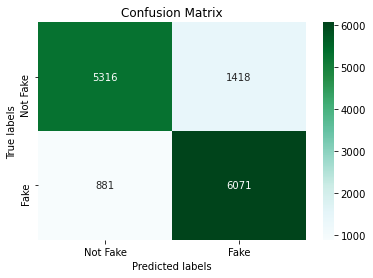

In [57]:
train_model(clf_lr, train_avgw2v, y_train, test_avgw2v, y_test)

<h4> Random Forest

In [58]:
clf_rf = RandomForestClassifier()

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26936
           1       1.00      1.00      1.00     27808

    accuracy                           1.00     54744
   macro avg       1.00      1.00      1.00     54744
weighted avg       1.00      1.00      1.00     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      6734
           1       0.86      0.89      0.87      6952

    accuracy                           0.87     13686
   macro avg       0.87      0.87      0.87     13686
weighted avg       0.87      0.87      0.87     13686

____________________________________________________________



Train F1 score: 1.0
Test F1 score: 0.872

Train Accuracy: 1.0
Test Accuracy: 0.868

____________________________________

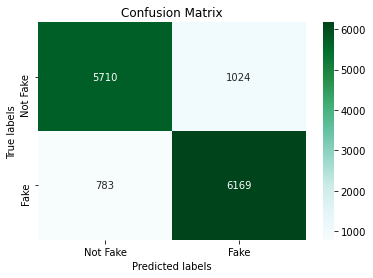

In [59]:
train_model(clf_rf, train_avgw2v, y_train, test_avgw2v, y_test)

#### Conclusion and Takeaways:
* With Logistic Regression we are getting a test accuracy of about 83% and a test F1 score of 0.84
* With the Random Forest Model, we do see overfitting with the train score hitting a 100% and the test giving 0.87. The overfitting can be tuned by hyper parameter tuning

##  Hyper-Parameter Tuning for the Logistic Regression Model with Bigrams and TFIDF

In [10]:
# Initializing the Model

model = LogisticRegression()

In [11]:
%%time
# Defining the param dictionary for Grid Search

params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
         'C' : [0.01, 0.1, 1.0, 10, 100], 
         'solver' : ['newton-cg', 'lbfgs', 'liblinear']}

# Optimizing the grid search on f1-score
clf = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=5, n_jobs=-1)

clf.fit(train_tfidf_bigram, y_train)

Wall time: 2min 44s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1')

In [13]:
# Printing the best parameters

clf.best_params_

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26936
           1       1.00      1.00      1.00     27808

    accuracy                           1.00     54744
   macro avg       1.00      1.00      1.00     54744
weighted avg       1.00      1.00      1.00     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6734
           1       0.98      0.99      0.99      6952

    accuracy                           0.98     13686
   macro avg       0.98      0.98      0.98     13686
weighted avg       0.98      0.98      0.98     13686

____________________________________________________________



Train F1 score: 1.0
Test F1 score: 0.985

Train Accuracy: 1.0
Test Accuracy: 0.985

____________________________________

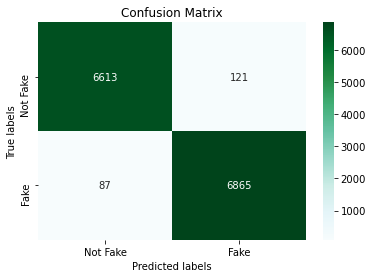

In [5]:
# Training a logistic Regression Model with the best parameters 

tuned_clf = LogisticRegression(penalty='l1', C=100, solver='liblinear')

train_model(tuned_clf, train_tfidf_bigram, y_train, test_tfidf_bigram, y_test)

## Comparing cross_val scores for Tuned LR Model and Untuned Model

In [15]:
# Measuring performance on a 5-Fold CV for untuned model

model = LogisticRegression()

scores_lr_acc = cross_val_score(estimator=model, X=train_tfidf_bigram, y=y_train, scoring='accuracy', cv=5, n_jobs=-1)
scores_lr_f1 = cross_val_score(estimator=model, X=train_tfidf_bigram, y=y_train, scoring='f1', cv=5, n_jobs=-1)

In [16]:
print(f"5-Fold Accuracy for the untuned model: {np.round(scores_lr_acc.mean()*100, 2)} %")
print(f"5-Fold F1 for the untuned model: {np.round(scores_lr_f1.mean(),4)}")

5-Fold Accuracy for the untuned model: 97.55 %
5-Fold F1 for the untuned model: 0.976


In [17]:
# Measuring performance on a 5-Fold CV for tuned model

model_tuned = LogisticRegression(penalty='l1', C=100, solver='liblinear')

scores_tuned_lr_acc = cross_val_score(estimator=model_tuned, X=train_tfidf_bigram, y=y_train, scoring='accuracy', cv=5, n_jobs=-1)
scores_tuned_lr_f1 = cross_val_score(estimator=model_tuned, X=train_tfidf_bigram, y=y_train, scoring='f1', cv=5, n_jobs=-1)

In [18]:
print(f"5-Fold Accuracy for the tuned model: {np.round(scores_tuned_lr_acc.mean()*100, 2)} %")
print(f"5-Fold F1 for the tuned model: {np.round(scores_tuned_lr_f1.mean(),4)}")

5-Fold Accuracy for the tuned model: 98.45 %
5-Fold F1 for the tuned model: 0.9846


In [7]:
# Saving the classifer

file_name = 'model.pkl'
 
with open(file_name, 'wb') as file:
    pickle.dump(tuned_clf, file)

##  Hyper-Parameter Tuning for the XGBoost classifier with W2V

In [5]:
# Initializing the model 

xgb_model = XGBClassifier(n_jobs=6)

In [6]:
%%time
# Defining the param dictionary for Grid Search

params = {"learning_rate"    : [0.1, 0.2, 0.3] ,
          "max_depth"        : [3, 6, 9, 12],
          "gamma"            : [ 0.0, 0.2, 0.4 ]}

# Optimizing the grid search on f1-score
clf = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='f1', cv=3, n_jobs=6)

clf.fit(train_w2vgoogle, y_train)

[18:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2h 56min 18s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=6,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [7]:
# Printing the best parameters 

clf.best_params_

{'gamma': 0.4, 'learning_rate': 0.3, 'max_depth': 6}

[19:10:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
____________________________________________________________

Train set report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26936
           1       1.00      1.00      1.00     27808

    accuracy                           1.00     54744
   macro avg       1.00      1.00      1.00     54744
weighted avg       1.00      1.00      1.00     54744


************************************************************

Test set report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6734
           1       0.92      0.94      0.93      6952

    accuracy                         

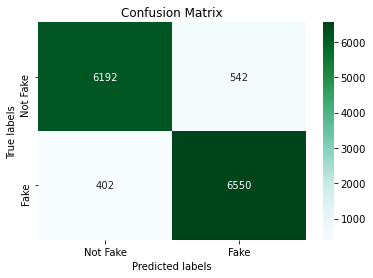

In [8]:
# Training an XGBoost Model with the best parameters 

tuned_clf = XGBClassifier(gamma=0.4, learning_rate=0.3, max_depth=6)

train_model(tuned_clf, train_w2vgoogle, y_train, test_w2vgoogle, y_test)

### Conculusions and takeaways
* Logistic Regession after tuning the parameters is able to achieve a test accuracy of 98.5% and a test F1 score of 0.933
* XGBoost with a bit of hyperparameter tuning stays at 93.1 % test accuracy and is overfitting a bit. There can be further experimentation with the regularization parameters but the entire process is very time consuming
* Since Logistic Regression is already giving us great results, we'll stick to Logistic Regression

# Model Calibration

In [5]:
# Reading the model pickle file to load the model

with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

In [6]:
calibrated_model = CalibratedClassifierCV(model, cv='prefit')

In [8]:
calibrated_model.fit(train_tfidf_bigram, y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=100, penalty='l1',
                                                         solver='liblinear'),
                       cv='prefit')

In [10]:
# Saving the calibrated model

file_name = 'calibrated_model.pkl'
 
with open(file_name, 'wb') as file:
    pickle.dump(calibrated_model, file)

# Takeaways
* Logistic Regression when paired with TFIDF and bigrams yields the best test scores.
* The test F1 score obtained was 0.985 and test accuracy was 98.5%.
* Its clear that linear models work really well with high dimensionality and can even outperform tree based classifiers.